<a href="https://colab.research.google.com/github/Gamma1024/ML_in_Finance/blob/main/ClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Finance: Final Project of Group 2


## Exploratory Data Analysis

In [3]:
############## Importing Necessary Packages ##############
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from numpy import isnan
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable


In [4]:
!git clone https://github.com/Gamma1024/ML_in_Finance.git

Cloning into 'ML_in_Finance'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [5]:
############## Loading The Data ##############
## Loading findata
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
findata_2014 = pd.read_csv("ML_in_Finance/Data/2014_Financial_Data.csv", index_col = 0)
findata_2015 = pd.read_csv("ML_in_Finance/Data/2015_Financial_Data.csv", index_col = 0)
findata_2016 = pd.read_csv("ML_in_Finance/Data/2016_Financial_Data.csv", index_col = 0)
findata_2017 = pd.read_csv("ML_in_Finance/Data/2017_Financial_Data.csv", index_col = 0)
findata_2018 = pd.read_csv("ML_in_Finance/Data/2018_Financial_Data.csv", index_col = 0)
print(findata_2014.shape)
print(findata_2015.shape)
print(findata_2016.shape)
print(findata_2017.shape)
print(findata_2018.shape)
findata_2014._get_numeric_data().columns.shape
is_numeric_dtype(findata_2014["Sector"]) # categorical variable we need to convert later on

(3808, 224)
(4120, 224)
(4797, 224)
(4960, 224)
(4392, 224)


False

The original task on [kaggle](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018) was to classify the data into buy-worthy and non-buy-worthy stocks. For this task the last column consists of the dummy variable "Class" which indicates whether one should buy or not buy a particular stock in the beginning of the corresponding year. Hence, we need to transform the column "Class" so that it can take the values 0 for **Sell**, 1 for **Hold** and 2 for **Buy**. For this we calculate the excess return over the benchmark i.e. the S&P 500 and classify the stocks based on their excess return into the classes 2/Buy if excess_return > 2.5%, 1/Hold if excess_return $\in$ [-2.5%, 2.5%] and 0/Sell if excess_return < -2.5%. Later on we want to concatenate the dataframes and therefore we change the name of the columns "201x PRICE VAR [%]" to "PRICE VAR [%]" so that the name of the variable is the same for all years.

In [6]:
############## Change Variable "Class" ##############
## Yearly Means of S&P 500
sp500_means = pd.Series([11.39, -0.73, 9.54, 19.42, -6.24], 
                        index = ["2014", "2015", "2016", "2017", "2018"])
print(sp500_means)

looplist = [[findata_2014, "2015 PRICE VAR [%]", "2014"], [findata_2015, "2016 PRICE VAR [%]", "2015"], [findata_2016, "2017 PRICE VAR [%]", "2016"],
            [findata_2017, "2018 PRICE VAR [%]", "2017"], [findata_2018, "2019 PRICE VAR [%]", "2018"]]
for data, price_var, year in looplist:
   ## Subtracting S&P 500 means to get excess return
   # e.g. findata_2014["excess_return"] = np.subtract(findata_2014["2015 PRICE VAR [%]"], sp500_means[0])
   data["excess_return"] = np.subtract(data[price_var], sp500_means[year])
   ## rename the columns 201x PRICE VAR [%] to PRICE VAR [%] to concatenate
   data.columns = ["PRICE VAR [%]" if x == price_var else x for x in data.columns]
   ## Reassigning Class
   # class 2 if excess_return>2.5, 0 if excess_return < -2.5, else class 1
   data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))
   print(data["PRICE VAR [%]"].isna().sum())
# no NA's in the column "PRICE VAR [%]"

print(findata_2014.iloc[::,222:225].head()) # column 223 is "Class", 224 is "excess_return"

2014    11.39
2015    -0.73
2016     9.54
2017    19.42
2018    -6.24
dtype: float64
0
0
0
0
0
      PRICE VAR [%]  Class  excess_return
PG        -9.323276      0     -20.713276
VIPS     -25.512193      0     -36.902193
KR        33.118297      2      21.728297
RAD        2.752291      0      -8.637709
GIS       12.897715      1       1.507715


In [7]:
# %%timeit
# for data in [findata_2014, findata_2015, findata_2016, findata_2017, findata_2018]:
#    data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))

In [8]:
############## Concatenating the Data ##############
## Concatenate the Data
frames = [findata_2014, findata_2015, findata_2016, findata_2017,
          findata_2018]
findata = pd.concat(frames)

## Let's investigat our newly created dataframe a bit:
print(findata.shape)
print(findata.head(3))
print(findata.info())
print(findata[["excess_return", "PRICE VAR [%]"]].describe())
print("-------------------------------------------------------------------------")
print(pd.crosstab(index = findata["Sector"], columns = findata["Class"], margins = True)) 
print("-------------------------------------------------------------------------")
print(pd.crosstab(index = findata["Sector"], columns = findata["Class"], normalize = "index"))

(22077, 225)
           Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
PG    7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
KR    9.837500e+10          0.0182     7.813800e+10  2.023700e+10   

      R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
PG    0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
VIPS  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
KR    0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   

      Interest Expense  Earnings before Tax  ...  Inventory Growth  \
PG        7.090000e+08         1.449400e+10  ...           -0.0217   
VIPS      1.214869e+07         1.753823e+08  ...               NaN   
KR        4.430000e+08         2.270000e+09  ...            0.0981   

      Asset Growth  Book Value per Share Growth  Debt Growth  \
PG          0.0359                       0.0316       0.1228   
VIPS

We see that the mean is a lot bigger than the median for the excess_return and the PRICE VAR [%] indicating a right skewed distribution. Further investigations below show that the reason for this is that there are a few companies whose returns were (sometimes much) greater than 1000% percent and thus levereging the mean.

-5.281841982079795
GNL     2.418601e+06
BW      6.955667e+05
NK      1.732000e+05
PUB     1.443588e+05
RUN     7.836667e+04
BKI     6.602000e+04
SUM     4.023329e+04
JP      2.520000e+04
JAX     2.416667e+04
OPNT    1.960000e+04
AMRH    1.310000e+04
PEN     9.864815e+03
PJT     6.799999e+03
FSB     5.843182e+03
YRIV    2.933333e+03
LBCC    2.292857e+03
CC      2.248621e+03
GBT     1.993912e+03
SSNT    1.041667e+03
BSM     1.000607e+03
Name: PRICE VAR [%], dtype: float64
RHE    -100.397220
ARA     -98.333333
FTAI    -98.289550
AAMC    -94.755181
RGSE    -94.272727
GLBS    -93.913044
EIGR    -92.711948
AEZS    -92.533333
TELL    -92.527174
SCON    -92.500000
COE     -92.299086
APEN    -91.929825
RSLS    -91.268447
CPST    -90.540541
SBLK    -90.032680
NXTD    -89.915966
GOL     -89.560440
USEG    -89.333333
YUMA    -89.204545
NSPR    -89.000000
Name: PRICE VAR [%], dtype: float64


(0.0, 0.9)

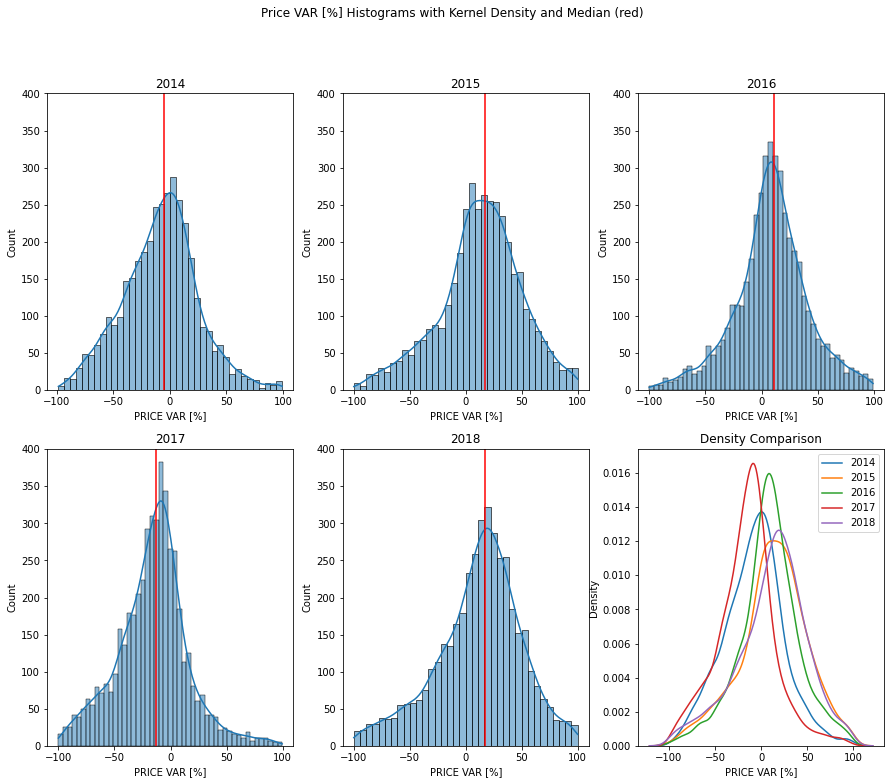

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

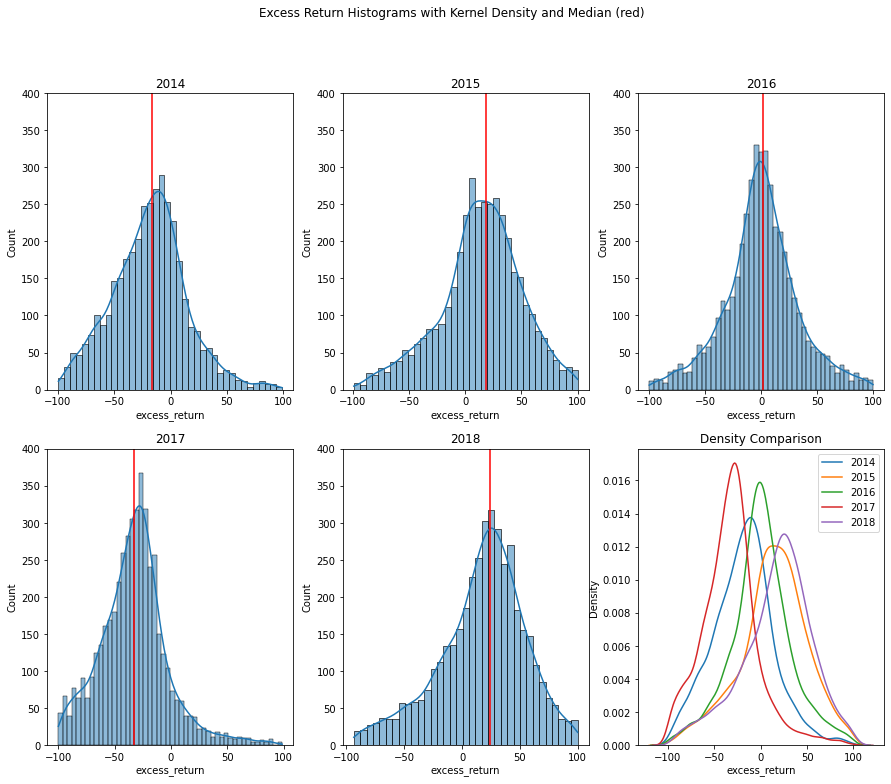

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

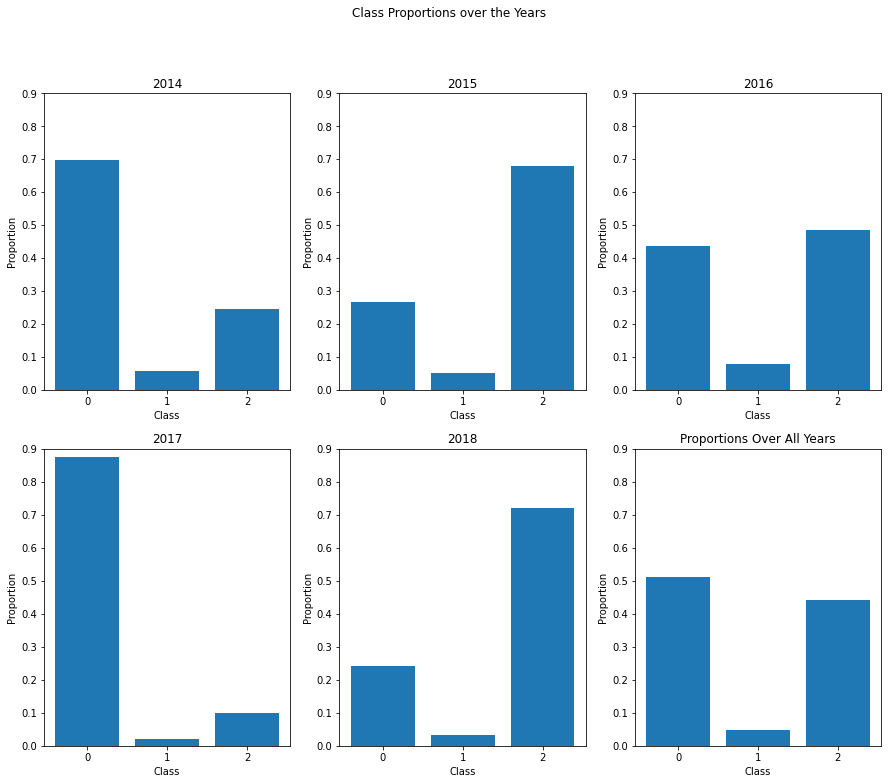

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
############## Further Investigations ##############
print(np.median(findata_2014.iloc[:, 222]))
print(findata_2014.iloc[:, 222].nlargest(n = 20)) 
print(findata_2014.iloc[:, 222].nsmallest(n = 20))
# very extreme returns, thus need to adjust xrange in plots to not get range from min to max observation
plotloop = [[findata_2014, "2014", 0], [findata_2015, "2015", 1], [findata_2016, "2016", 2], [findata_2017, "2017", 3], [findata_2018, "2018", 4]]

## Plot Histogram of Price VAR [%] for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) # create plot matrix with 2 rows and 3 columns
fig.suptitle("Price VAR [%] Histograms with Kernel Density and Median (red)")
ax = ax.ravel() # flatten the axis array
for data, year, k in plotloop:
  data_hist = data.iloc[:, 222][data.iloc[:, 222].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 222]), color="red") # vertical line with median of the column PRICE VAR [%] of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Histogram of excess_return for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Excess Return Histograms with Kernel Density and Median (red)")
ax = ax.ravel()
for data, year, k in plotloop:
  data_hist = data.iloc[:, 224][data.iloc[:, 224].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 224]), color="red") # vertical line with median of the column excess_return of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Barplot of proportion of Class for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Class Proportions over the Years")
ax = ax.ravel()
y_pos = np.arange(3)
for data, year, k in plotloop:
  ax[k].set_title(year)
  plt.figure()
  ax[k].set_xlabel("Class") # set common x label
  ax[k].set_ylabel("Proportion") # set common y label
  height = [sum(data["Class"] ==0)/data.shape[0], sum(data["Class"] ==1)/data.shape[0], sum(data["Class"] ==2)/data.shape[0]]
  ax[k].bar(y_pos, height)
  ax[k].set_xticks([0, 1, 2]) 
  ax[k].set_xticklabels([0, 1, 2])
  ax[k].set_ylim(0, 0.9)
sell_prop  = sum(findata["Class"] == 0)/findata.shape[0]
hold_prop = sum(findata["Class"] == 1)/findata.shape[0]
buy_prop = sum(findata["Class"] ==2)/findata.shape[0]
height = [sell_prop, hold_prop, buy_prop]
ax[5].bar(y_pos, height)
ax[5].set_xticks([0, 1, 2]) 
ax[5].set_xticklabels([0, 1, 2])
ax[5].set_xlabel("Class")
ax[5].set_ylabel("Proportion")
ax[5].set_title("Proportions Over All Years")
ax[5].set_ylim(0, 0.9)

PG             NaN
VIPS           NaN
KR             NaN
RAD     33998000.0
GIS            NaN
Name: Preferred Dividends, dtype: float64

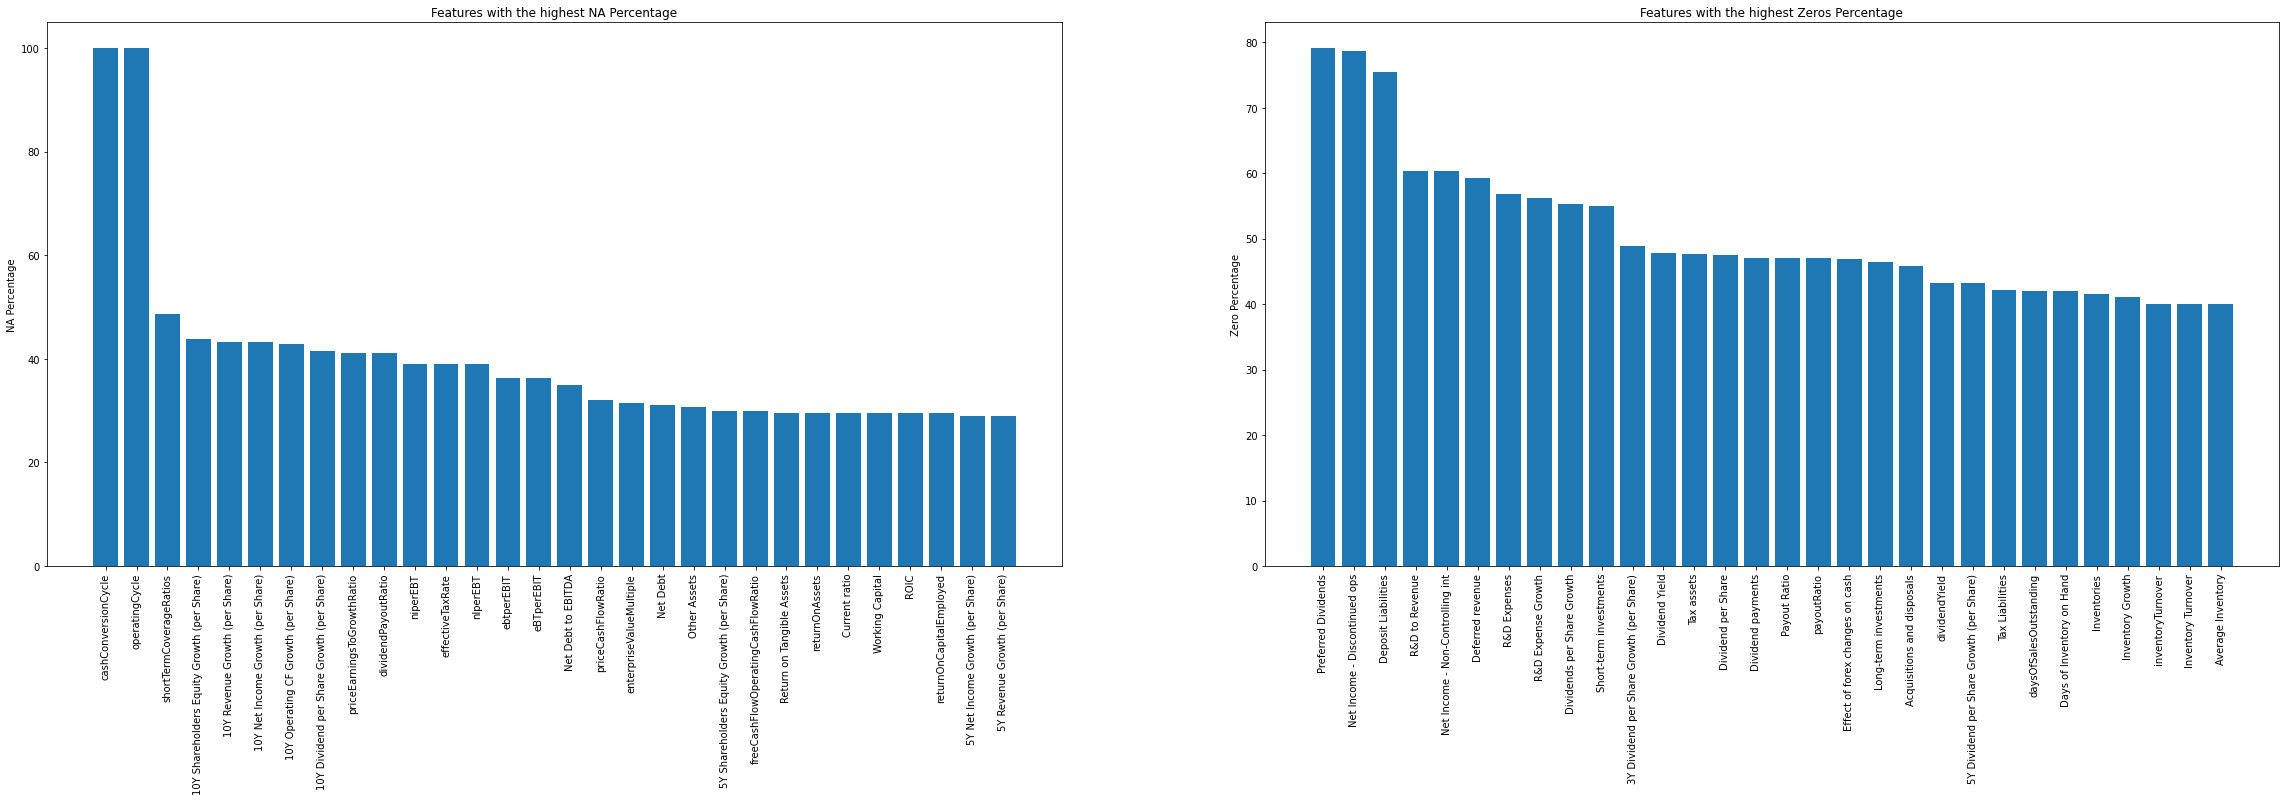

In [10]:
############## Nas and Zeros in the Dataset ##############
## Calculating the Percentage of NAs/Zeros
# Percentage of NAs:
na_percent = (findata.isna().sum()/findata.shape[0]*100).sort_values(ascending = False)
# Percentage of Zeros of all columns but response Class:
zero_percent = (findata.loc[:, findata.columns != "Class"].isin([0]).sum()/findata.shape[0]*100).sort_values(ascending = False)

## Plotting the Results
fig, ax = plt.subplots(nrows = 1, ncols = 2 , figsize=(40, 10))
ax = ax.ravel()

na_labels = na_percent[0:30].index.values.tolist()
ax[0].bar(np.arange(30), na_percent[0:30].values.tolist())
ax[0].set_xticks(np.arange(30))
ax[0].set_ylabel("NA Percentage")
ax[0].set_xticklabels(na_labels, rotation=90)
ax[0].set_title("Features with the highest NA Percentage")

zero_labels =  zero_percent[0:30].index.values.tolist()
ax[1].bar(np.arange(30), zero_percent[0:30].values.tolist())
ax[1].set_xticks(np.arange(30))
ax[1].set_ylabel("Zero Percentage")
ax[1].set_xticklabels(zero_labels, rotation=90)
ax[1].set_title("Features with the highest Zeros Percentage")

## Convert 0s to NAs
findata.iloc[:,0:222] = findata.iloc[::,0:222].replace({"0" : np.nan, 0 : np.nan})
findata["Preferred Dividends"].head(5) # making sure it has worked

While analyzing the data, we realized that NA's and the value 0 are used interchangeably. To make the data uniform, we decided to convert the 0's into NA's. For 3 columns, however, the 0's could actually represent the true values. These columns are "Tax Liabilities", "Preferred Dividends" and "Goodwill and intangible assets". However, because a high proportion of these columns have the value 0, these features are not informative either way and we decided to drop them. As a consequence, we decided to convert the 0's in all columns to NA's.

In [11]:
############## Remove Identical Columns ##############
na_sum = findata.isna().sum()
na_sum_series = na_sum.squeeze() # convert data frame to pandas series
print(na_sum_series.sort_values(ascending = False).head(10)) # sort values in descending order

identical_columns = [] # create empty list to store identicao columns
for i in range(findata.shape[1]):
  for j in range(i+1, findata.shape[1]):
    if findata.iloc[:, i].equals(findata.iloc[:, j])==1: # pairwise compare columns whether they are identical or not
      identical_columns.append([findata.columns[i], findata.columns[j]]) # append identical columns to list identical_columns
for column1, column2 in identical_columns:
  findata.drop(column1, axis = 1, inplace = True) # drop one of the two columns that are identical
print(identical_columns)
findata.shape # 11 columns identical since we went from 225 to 214 columns

cashConversionCycle                          22058
operatingCycle                               22058
Preferred Dividends                          19717
Net Income - Discontinued ops                19620
Deposit Liabilities                          18935
10Y Dividend per Share Growth (per Share)    16089
R&D to Revenue                               15585
Net Income - Non-Controlling int             15567
5Y Dividend per Share Growth (per Share)     15308
Deferred revenue                             15086
dtype: int64
[['ebitperRevenue', 'eBITperRevenue'], ['ebtperEBIT', 'eBTperEBIT'], ['niperEBT', 'nIperEBT'], ['returnOnAssets', 'Return on Tangible Assets'], ['returnOnCapitalEmployed', 'ROIC'], ['payablesTurnover', 'Payables Turnover'], ['inventoryTurnover', 'Inventory Turnover'], ['daysOfSalesOutstanding', 'Days of Inventory on Hand'], ['debtRatio', 'Debt to Assets'], ['debtEquityRatio', 'Debt to Equity'], ['cashFlowToDebtRatio', 'cashFlowCoverageRatios']]


(22077, 214)

0.1-->182 observations left out

In [12]:
############## NA Threshold ##############
na_threshold = 0.3 # threshold for NA percentage
print(sum(findata.isna().mean() > na_threshold)) # 75 of the remaining variables have more than 30% NAs
findata = findata.loc[::, findata.isna().mean() < na_threshold] # drop all columns with NA proportion higher than threshold
findata[["Class", "Sector"]].dtypes
findata.shape

75


(22077, 139)

In [13]:
############## Train-Test Split ##############
## Convert Sector& Class to Factors
# create dummies in place of the original Sector variable each with the prefix "Sector" in its variable name
findata = pd.concat([findata, pd.get_dummies(findata["Sector"], prefix="Sector")],axis=1).drop(["Sector"],axis=1) 
label_encoder  = pp.LabelEncoder()
findata["Class"] = label_encoder.fit_transform(findata["Class"])
pd.factorize(findata["Class"])
print(findata.iloc[:,-15:].head(3))
print(findata.shape)
X = findata.drop(["Class", "excess_return", "PRICE VAR [%]"], axis = 1) # all columns but response Class and the variables we needed to classify the stocks
y = findata['Class']
print(y.value_counts()) # Upsampling required (but only after train-test split)

## Train-Test Split
# To impute the missing values we need to first split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.1, random_state = 42) # Train-Test Split 90:10 according to Script/ Raschka (2015)
# Print proportions of each class in the train set
print(f"Sell proportion:  {sum(y_train ==0)/X_train.shape[0]: .6f}")
print(f"Hold proportion:  {sum(y_train ==1)/X_train.shape[0]: .6f}")
print(f"Buy proportion: {sum(y_train ==2)/X_train.shape[0]: .6f}")


      SG&A Expenses Growth  PRICE VAR [%]  Class  excess_return  \
PG                 -0.1746      -9.323276      0     -20.713276   
VIPS                1.7313     -25.512193      0     -36.902193   
KR                  0.0234      33.118297      2      21.728297   

      Sector_Basic Materials  Sector_Communication Services  \
PG                         0                              0   
VIPS                       0                              0   
KR                         0                              0   

      Sector_Consumer Cyclical  Sector_Consumer Defensive  Sector_Energy  \
PG                           0                          1              0   
VIPS                         0                          1              0   
KR                           0                          1              0   

      Sector_Financial Services  Sector_Healthcare  Sector_Industrials  \
PG                            0                  0                   0   
VIPS                     

Now it is time to fill the missing values using the KNN imputer. The following code block may take some minutes to execute.

In [14]:
############## Imputation ##############
# First use X_train to fit the imputer, then apply it to X_train and X_test
# Important: We DO NOT use X_test to fit the imputer seperately
imputer = KNNImputer(n_neighbors = 5, weights = "uniform") # n_jobs = -1 to use all CPU cores
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print("NAs remaining: ", sum(isnan(X_train).flatten()))
print("NAs remaining: ", sum(isnan(X_test).flatten()))

NAs remaining:  0
NAs remaining:  0


We have learnt in the lecture that decision tree algorithms are insensitive to the data's magnitude unlike other algorithms like e.g. PCA or SVM. Consequently, there exists a decision tree algorithm called Isolation Forest that can detect anomalies/ outliers in the data. Below we make use of this algorithm:

In [15]:
############## Outlier Detection ##############
## Isolation Forest
outliers = IsolationForest(random_state = 42).fit(X_train) # fit Isolation Forest to training data
outliers_train = outliers.predict(X_train)
outliers_test = outliers.predict(X_test)

## Remove outliers where 1 represent inliers and -1 represent outliers:
X_train_cleaned = X_train[np.where(outliers_train == 1, True, False)]
y_train_cleaned = y_train[np.where(outliers_train == 1, True, False)]
X_test_cleaned = X_test[np.where(outliers_test == 1, True, False)]
y_test_cleaned = y_test[np.where(outliers_test == 1, True, False)]
print("Shape with outliers: ", X_train.shape,", Shape without outliers: ", X_train_cleaned.shape,", Removed outliers: ", X_train.shape[0]-X_train_cleaned.shape[0])
print("Shape with outliers: ", X_test.shape,", Shape without outliers: ", X_test_cleaned.shape,", Removed outliers: ", X_test.shape[0]-X_test_cleaned.shape[0]) 

## Print proportions of each class in cleaned data set
sell_prop_trainc = sum(y_train_cleaned == 0)/X_train_cleaned.shape[0]
hold_prop_trainc = sum(y_train_cleaned == 1)/X_train_cleaned.shape[0]
buy_prop_trainc = sum(y_train_cleaned == 2)/X_train_cleaned.shape[0]
print(f"Sell proportion:  {sell_prop_trainc: .6f}")
print(f"Hold proportion:  {hold_prop_trainc: .6f}")
print(f"Buy proportion:  {buy_prop_trainc: .6f}")

Shape with outliers:  (19869, 146) , Shape without outliers:  (19620, 146) , Removed outliers:  249
Shape with outliers:  (2208, 146) , Shape without outliers:  (2177, 146) , Removed outliers:  31
Sell proportion:   0.510499
Hold proportion:   0.048114
Buy proportion:   0.441386


For upsampling we first agreed upon using SMOTE (Synthetic Minority Oversampling TEchnique) which contrary to upsampling using the resample() function creates new, additional observations that increase the variation within the data and thus provides additional information to the model. The biggest problem with using SMOTE() was that the newly created samples of the categorical variables are numerical and not categorical. To make sure categorical variables stay categorical there would exist the SMOTENC() function that requires the categorical variables to not be one-hot-encoded. Since we had to one-hot-encode the Sector variable to apply the KNN imputer we decided to use neither from the SMOTE functions. Instead we used RandomOverSampler of the imblearn package. The biggest advantage of RandomOverSampler over resample is that it can be easily introduced as a step in a pipeline. t is important to note that the pipeline implementation does not work using the sklearn pipeline but one has to use the imb pipeline instead. The biggest advantage of this pipeline implementation is that this way the k-fold cross validation train scores are closer to test scores. 

In [16]:
############## Upsampling ##############
######### Also try Resampling using Resample()
# smote= SMOTE(random_state = 42)
# # Upsampling is done only in the training set!!!
# X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_cleaned, y_train_cleaned)
# # We use _upsampled only for models without hyperparameters to tune
# # Otherwise the upsampling is implemented in the pipeline
# print(y_train_upsampled.value_counts()) # all classes have equally many observations
# y_train_upsampled
# X_train_upsampled[:, -1]
# for i in np.arange(1, 12, 1):
#   print(sum((X_train_upsampled[:, -i]!=0)&(X_train_upsampled[:, -i]!=1)))
#   X_train_upsampled[:,-i] = np.round(X_train_upsampled[:,-i])
# print(sum((X_train_upsampled[:, -1]!=0)&(X_train_upsampled[:, -1]!=1)))
# print(sum((y_train_upsampled!=0)&(y_train_upsampled!=1)&(y_train_upsampled!=2)))

In [17]:
############## Upsampling ##############
# X_train_hold = X_train_cleaned[y_train_cleaned==1]
# X_train_buy = X_train_cleaned[y_train_cleaned==2]
# X_train_sell = X_train_cleaned[y_train_cleaned==0]
# y_train_sell = y_train_cleaned[y_train_cleaned==0]
# ### Now, downsamples majority labels equal to the number of samples in the minority class

# X_train_hold_upsampled, y_train_hold_upsampled = resample(X_train_hold, y_train_cleaned[y_train_cleaned==1], replace = True, 
#                                                           n_samples = X_train_sell.shape[0], random_state = 42)
# X_train_buy_upsampled, y_train_buy_upsampled = resample(X_train_buy, y_train_cleaned[y_train_cleaned==2], replace = True, 
#                                                           n_samples = X_train_sell.shape[0], random_state = 42)

# ### concat the majority and minority dataframes
# X_train_upsampled = pd.concat([pd.DataFrame(X_train_hold_upsampled), pd.DataFrame(X_train_buy_upsampled),pd.DataFrame(X_train_sell)])
# y_train_upsampled = pd.concat([pd.DataFrame(y_train_hold_upsampled), pd.DataFrame(y_train_buy_upsampled),pd.DataFrame(y_train_sell)])



# ## Shuffle the dataset to prevent the model from getting biased by similar samples
# X_train_upsampled = X_train_upsampled.sample(frac=1, random_state= 42)
# y_train_upsampled = y_train_upsampled.sample(frac=1, random_state= 42)

# for i in np.arange(1, 12, 1):
#   print(sum((X_train_upsampled[:, -i]!=0)&(X_train_upsampled[:, -i]!=1)))
#   X_train_upsampled[:,-i] = np.round(X_train_upsampled[:,-i])
# print(sum((X_train_upsampled[:, -1]!=0)&(X_train_upsampled[:, -1]!=1)))
# print(sum((y_train_upsampled!=0)&(y_train_upsampled!=1)&(y_train_upsampled!=2)))

Text(0.5, 1.0, 'Correlation Heatmap')

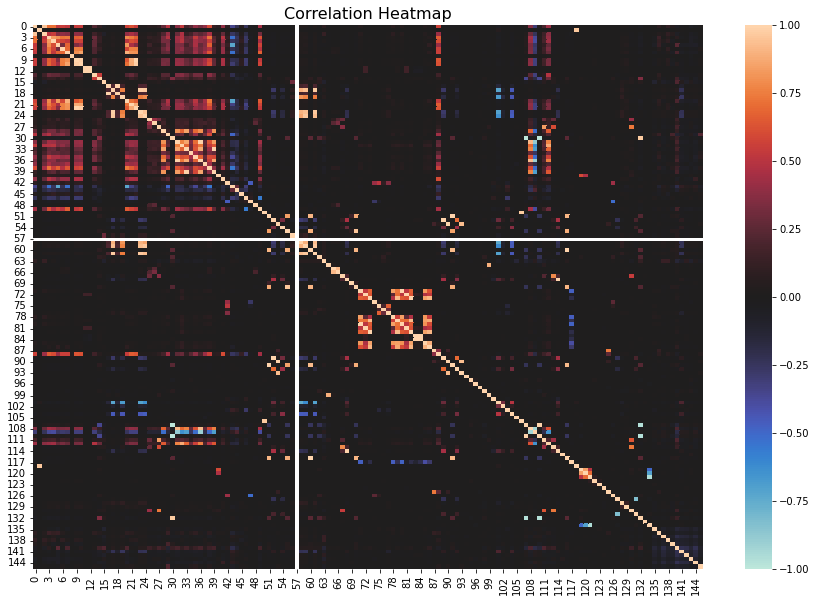

In [18]:
############## Correlation Matrix ##############
corr = pd.DataFrame(X_train_cleaned).corr()
plt.figure(figsize=(15,10)) 
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, center = 0) # heatmap of correlation
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize":16})

We can see that few of the features are highly correlated but many are only barely correlated. Thus, there might be some problems with (linear) PCA since we have many variables that are hardly correlated. Note that correlation only measures the **linear** relationship between the variables and the variables might be dependent in a non-linear way like it is the case with e.g. ratios.  Hence, a non linear dimension reduction approach like e.g. Sigmoid Kernel PCA might yield better results.

In [19]:
############## Summary Statistics ##############
## k-fold Cross Validation
kFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# 5 splits since findata is a large dataset (see script)
## Standardizing
sc = StandardScaler()
# X_train_std = sc.fit_transform(X_train_upsampled)
# X_test_std = sc.fit_transform(X_test_cleaned)

 1 Earnings Yield 0.0109
 2 Book Value per Share Growth 0.0101
 3 Free Cash Flow growth 0.0097
 4 Weighted Average Shares Growth 0.0095
 5 Operating Cash Flow growth 0.0095
 6 Issuance (buybacks) of shares 0.0094
 7 Revenue Growth 0.0094
 8 Receivables growth 0.0094
 9 Asset Growth 0.0094
10 Gross Profit Growth 0.0091
11 Net cash flow / Change in cash 0.0090
12 3Y Shareholders Equity Growth (per Share) 0.0089
13 Weighted Average Shares Diluted Growth 0.0088
14 Operating Income Growth 0.0088
15 SG&A Expenses Growth 0.0088
16 3Y Revenue Growth (per Share) 0.0088
17 PB ratio 0.0087
18 Weighted Average Shs Out (Dil) 0.0086
19 EV to Free cash flow 0.0085
20 Debt Growth 0.0085
21 dividendpaidAndCapexCoverageRatios 0.0085
22 Net Income Growth 0.0084
23 cashFlowCoverageRatios 0.0083
24 SG&A to Revenue 0.0083
25 EPS Diluted Growth 0.0083
26 priceBookValueRatio 0.0083
27 EPS Growth 0.0083
28 Income Tax Expense 0.0082
29 EBIT Growth 0.0082
30 operatingCashFlowSalesRatio 0.0082
31 Issuance (repaym

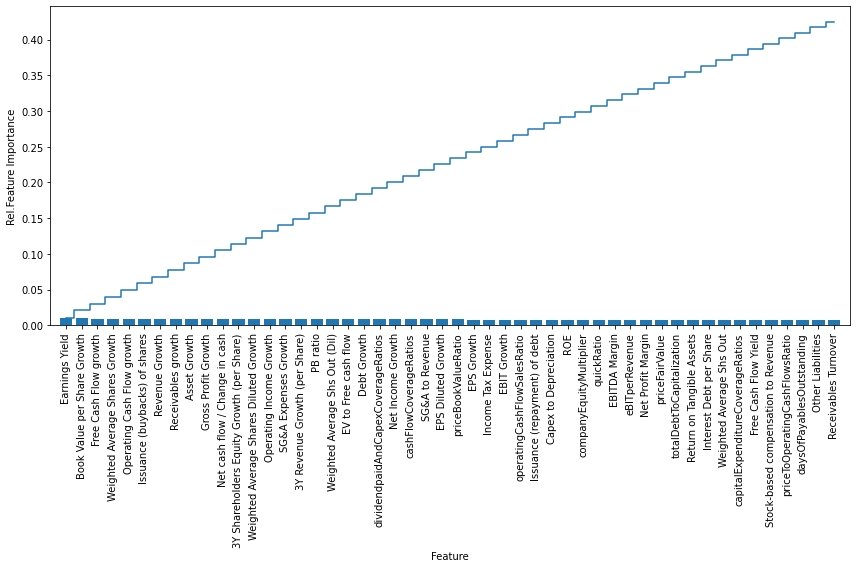

In [20]:
############## Feature Selection ##############
feat_labels = findata.columns [:-1]   
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train_cleaned , y_train_cleaned )
importances = forest.feature_importances_
indices = np.argsort( importances )[:: -1]
n = 50
for i in range ( n ):
  print('{0:2d} {1:7s} {2:6.4f}'.format(i+1,feat_labels[indices[i]],importances[indices[i]]))

feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

plt.figure(figsize =(12, 8))
plt.bar(range(n),importances[indices[:n]],align = "center")
plt.xticks (range(n),feat_labels[indices[:n]],rotation =90)
plt.xlim ([-1,n])
plt.xlabel("Feature")
plt.ylabel("Rel.Feature Importance")
plt.step(range(n),sum_feat_imp,where="mid", label = "Cumulative importance")
plt.tight_layout();

## Model Fitting

### Performance Metric
For scoring our models we will be using the weighted $F_1$-Score.

In [21]:
############## Report Functions ##############
# Function to get best parametrs, mean cross-validation score of best parameters, standard deviation of the cross-validation scores of the best parameters
# and the score of the test set
def get_results_cv(func, X_test_cleaned, y_test_cleaned):
  """
  Inputs required: already fitted gridsearcv or randomsearchcv function, cleaned X test set, cleaned y test set
  Returns best parameters, mean score, sd of score of cross-validation. Also returns test-score of best parameters
  """
  std_best_score = func.cv_results_["std_test_score"][func.best_index_]
  print(f"Best parameters: {func.best_params_}")
  print(f"Mean CV score: {func.best_score_: .6f}")
  print(f"Standard deviation of CV score: {std_best_score: .6f}")
  print("Test Score: {:.6f}".format(func.score(X_test_cleaned, y_test_cleaned)))

# Function to get metrics report and heatmap of the confusion matrics for the test set
def final_report(y_true, y_pred):
  """
  Inputs required: true classes, predicted classes
  Returns classification report and confusion matrix of the model
  """
  class_report = metrics.classification_report(y_true, y_pred)
  print(class_report)
  cm = confusion_matrix(y_true, y_pred, normalize = "all")
  cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
  plt.figure(figsize = (10,5))
  sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [22]:
?get_results_cv

In [23]:
?final_report

In [24]:
############## Ignore Filterwarnings ##############
# to avoid "UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples." spam
# for models where some element(s) in the confusion matrix is/are 0
warnings.filterwarnings("ignore") 

### Naive Classification/ Baseline

              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1111
           1       0.05      0.06      0.06       103
           2       0.44      0.45      0.45       963

    accuracy                           0.46      2177
   macro avg       0.34      0.34      0.34      2177
weighted avg       0.47      0.46      0.47      2177



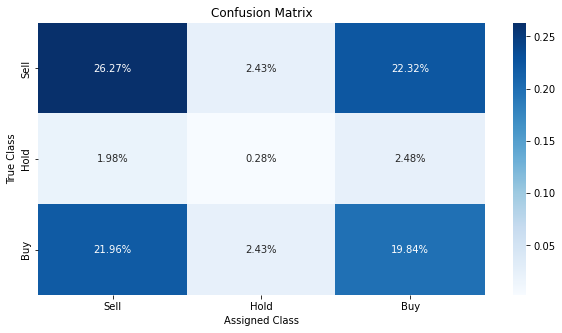

In [25]:
############## Naive Classification/ Baseline ##############
priors = [sell_prop_trainc, hold_prop_trainc, buy_prop_trainc]
np.random.seed(42) # set seed
# randomly choose classes 0, 1, 2 with probabilities based on proportions from X_train_cleaned
y_pred = np.random.choice([0, 1, 2], size = len(y_test_cleaned), replace = True, p = priors) 

final_report(y_test_cleaned, y_pred)

### Logistic Regression

Parameters of the logistic regression : dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])
Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.504547
Standard deviation of CV score:  0.003778
Test Score: 0.509120
              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1111
           1       0.00      0.00      0.00       103
           2       0.53      0.34      0.42       963

    accuracy                           0.54      2177
   macro avg       0.36      0.37      0.35      2177
weighted avg       0.51      0.54      0.51      2177



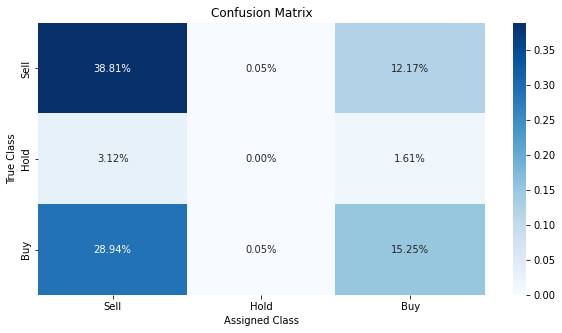

In [26]:
############## Logistic Regression ##############

####################
### All Features ###
####################
ros = RandomOverSampler(random_state = 42)
scaler = StandardScaler()
logistic = LogisticRegression(random_state=42, max_iter=20, n_jobs=-1)
# Get hyperparameters for logistic regression:
print(f"Parameters of the logistic regression : {logistic.get_params().keys()}")

# Set up pipeline
pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["classifier", logistic]])
# Set up parameter grid with hyperparameters we want to tune
param_grid = {'ros': [ros, None], # upsampling or not
              'scaler': [scaler, None], # standardizing input or not
              'classifier__C': [6, 7,8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}
# Conduct grid search with cross-validation to find hyperparameters that yield the best score
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
# Fit using the best parameters
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': None}
Mean CV score:  0.464785
Standard deviation of CV score:  0.059974
Test Score: 0.487788
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      1111
           1       0.01      0.01      0.01       103
           2       0.50      0.44      0.47       963

    accuracy                           0.48      2177
   macro avg       0.35      0.34      0.34      2177
weighted avg       0.49      0.48      0.49      2177



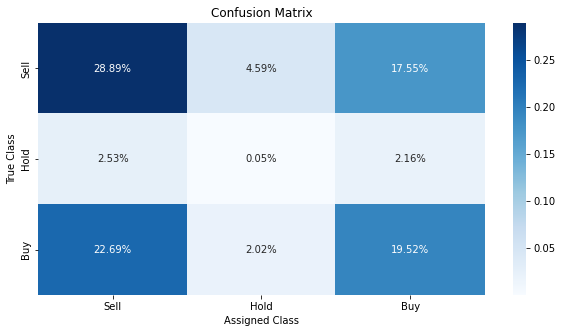

In [ ]:
############## Logistic Regression ##############

########################################
### Random Forest Feature Selection ###
########################################
forest = RandomForestClassifier(random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'ros': [ros, None],
              'scaler': [StandardScaler(), None],
              'classifier__C': [6, 7,8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)


Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.482814
Standard deviation of CV score:  0.021232
Test Score: 0.497197
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      1111
           1       0.00      0.00      0.00       103
           2       0.52      0.31      0.39       963

    accuracy                           0.53      2177
   macro avg       0.35      0.36      0.34      2177
weighted avg       0.50      0.53      0.50      2177



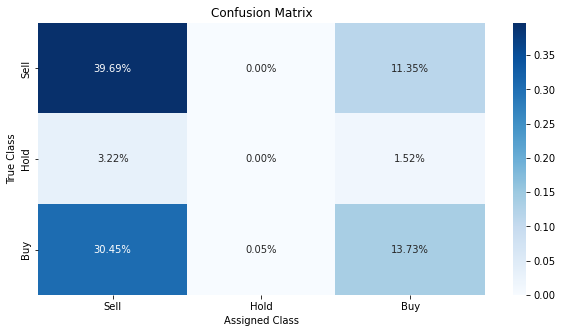

In [ ]:
############## Logistic Regression ##############

#################################
### XGBoost Feature Selection ###
#################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = xgbc, threshold = "median")],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'ros': [ros, None],
              'scaler': [StandardScaler(), None],
              'classifier__C': [6, 7,8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)


Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'pca__n_components': 12, 'ros': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}
Mean CV score:  0.464783
Standard deviation of CV score:  0.016633
Test Score: 0.461460
              precision    recall  f1-score   support

           0       0.58      0.32      0.42      1111
           1       0.11      0.36      0.16       103
           2       0.49      0.62      0.55       963

    accuracy                           0.45      2177
   macro avg       0.39      0.43      0.38      2177
weighted avg       0.52      0.45      0.46      2177



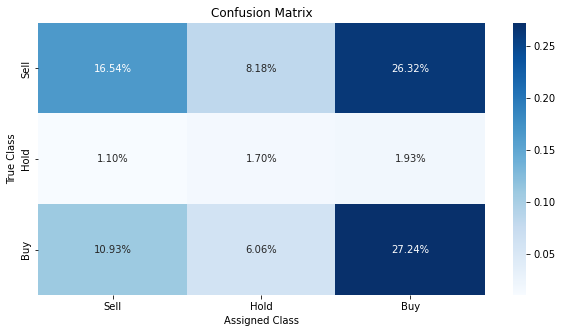

In [ ]:
############## Logistic Regression ##############

###############################
### PCA Dimension Reduction ###
###############################
pca = PCA(random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["pca",  pca],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'pca__n_components': np.arange(5, 16, 1),
              'ros': [ros, None],
              'scaler': [scaler, None],
              'classifier__C': [6, 7,8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)


We can see that the logistic regression using all features but no dimension reduction or feature selection tool performed the best and achieved a test $F_1$-Score of 0.49. Noteworthy is that the model achieved this score by standardizing the input but **without upsampling** it.

### (Gaussian) Naive Bayes Classifier
Fun fact: LDA is a special case of a naive Bayes classifier.

Parameters of the Gaussian Naive Bayes: dict_keys(['priors', 'var_smoothing'])
Best parameters: {'gnb__priors': [0.5104994903160041, 0.04811416921508665, 0.4413863404689093], 'gnb__var_smoothing': 0.7924828983539173, 'ros': RandomOverSampler(random_state=42), 'scaler': None}
Mean CV score:  0.357473
Standard deviation of CV score:  0.005990
Test Score: 0.363678
              precision    recall  f1-score   support

           0       0.51      0.99      0.67      1111
           1       0.00      0.00      0.00       103
           2       0.52      0.02      0.04       963

    accuracy                           0.51      2177
   macro avg       0.35      0.34      0.24      2177
weighted avg       0.49      0.51      0.36      2177



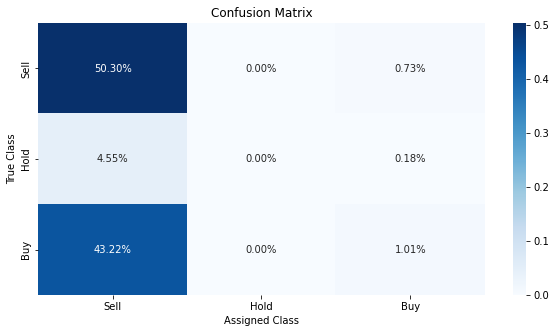

In [ ]:
############## Naive Bayes ##############

####################
### All Features ###
####################
gnb = GaussianNB()
print(f"Parameters of the Gaussian Naive Bayes: {gnb.get_params().keys()}")

pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["gnb", gnb]])
param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], # priors are either None or proportion of classes in train set calculated above
    "gnb__var_smoothing": np.logspace(0, -10, num = 100),
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)


get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'gnb__priors': [0.5104994903160041, 0.04811416921508665, 0.4413863404689093], 'gnb__var_smoothing': 3.5938136638046256e-05, 'ros': RandomOverSampler(random_state=42), 'scaler': None}
Mean CV score:  0.364616
Standard deviation of CV score:  0.011345
Test Score: 0.367909
              precision    recall  f1-score   support

           0       0.52      0.96      0.67      1111
           1       0.16      0.08      0.11       103
           2       0.49      0.02      0.05       963

    accuracy                           0.51      2177
   macro avg       0.39      0.36      0.27      2177
weighted avg       0.49      0.51      0.37      2177



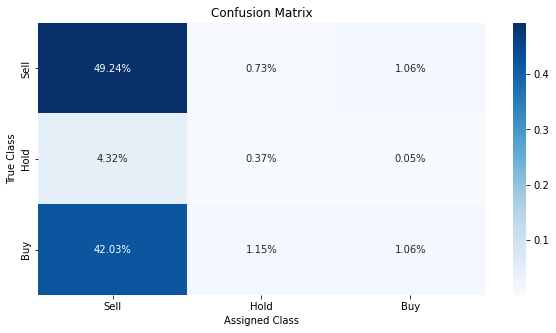

In [ ]:
############## Naive Bayes ##############

########################################
### Random Forest Feature Selectionn ###
########################################
forest = RandomForestClassifier(random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["gnb", gnb]])

param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 10),
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'gnb__priors': [0.5104994903160041, 0.04811416921508665, 0.4413863404689093], 'gnb__var_smoothing': 3.5938136638046256e-05, 'ros': RandomOverSampler(random_state=42), 'scaler': None}
Mean CV score:  0.364616
Standard deviation of CV score:  0.011345
Test Score: 0.367909
              precision    recall  f1-score   support

           0       0.52      0.96      0.67      1111
           1       0.16      0.08      0.11       103
           2       0.49      0.02      0.05       963

    accuracy                           0.51      2177
   macro avg       0.39      0.36      0.27      2177
weighted avg       0.49      0.51      0.37      2177



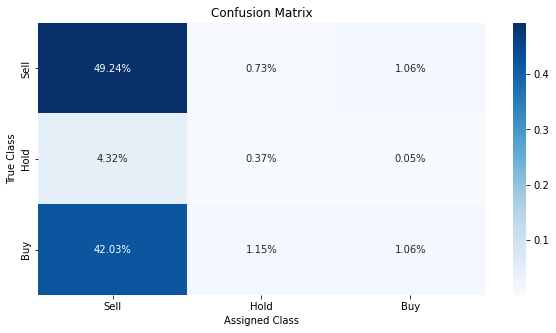

In [ ]:
############## Naive Bayes ##############

#################################
### XGBoost Feature Selection ###
#################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["gnb", gnb]])

param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 10),
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

The idea of Kernel PCA is to extend PCA to the non-linear case. For this we transform our variables X using a non-linear function $\varphi_k(\cdot)$ to X and then in a second step apply PCA to the transformed variables. Instead of doing an eigendecomposition of the variance-covariance matrix it can be shown that this problem is equivalent to solving $K\tilde{\alpha}=\tilde{\lambda}\tilde{\alpha}$ where K is a Kernel function (K has to be continuous, symmetric and positive-definite). Once we have $(\tilde{\alpha},\tilde{\lambda})$ we can obtain the eigenvalues& eigenvectors of the original problem. When using Kernel PCA the computational complexity only depends on the number of samples n and not of the number of features since K is a $n\times n$ matrix. Because we upsample in our pipeline the dimension of this matrix K quickly gets out of hand. Thus we decided to use RandomizedSearchCV to get a broad idea of the magnitude of the hyperparameters. Subsequently, we'll finetune these parameters using GridSearchCV. On a site note, there also exists the experimental [HalfGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [HalfRandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) that take an iterative approach and are supposed to yield similar results while being a lot faster. But from what we've gathered the accuracy and execution time strongly depends on the parameter choice of these Half functions and thus we decided to stay on familiar ground and use RandomizedSearchCV and GridSearchCV instead.

Best parameters: {'kpca__n_components': 9, 'kpca__kernel': 'sigmoid', 'kpca__gamma': 0.008333333333333333, 'kpca__coef0': 0.9777777777777777, 'gnb__var_smoothing': 1e-10}
Mean CV score:  0.477936
Standard deviation of CV score:  0.021631
Test Score: 0.488860
              precision    recall  f1-score   support

           0       0.54      0.71      0.61      1111
           1       0.06      0.04      0.05       103
           2       0.49      0.33      0.39       963

    accuracy                           0.51      2177
   macro avg       0.36      0.36      0.35      2177
weighted avg       0.49      0.51      0.49      2177



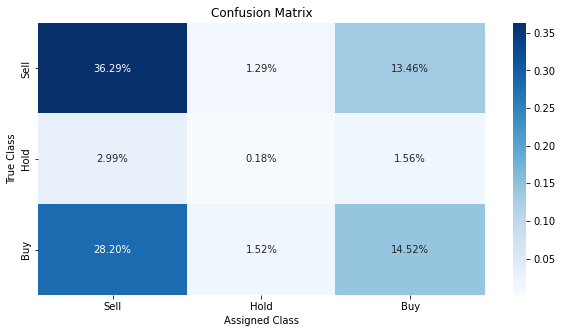

In [ ]:
############## Naive Bayes ##############

##################
### Kernel PCA ###
##################
gnb = GaussianNB(priors = priors)
kpca = KernelPCA(random_state = 42, eigen_solver = "arpack", n_jobs = -1)
# We used arpack since randomized requires matrix to be positive (semi-)definite
gnb_pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca], ["ros", ros], ["gnb", gnb]])
random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "sigmoid"], #linear is the "normal" PCA we have discussed in the lecture; only consider linear and sigmoid since we have ran it before and saw that sigmoid performed better than poly and rbf
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "kpca__coef0": np.linspace(0.8, 1.2, 10),
    "gnb__var_smoothing": np.logspace(0, -10, 10)
}


# gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
rs = RandomizedSearchCV(estimator = gnb_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")

rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'ros': RandomOverSampler(random_state=42), 'scaler': None}
Mean CV score:  0.466698
Standard deviation of CV score:  0.025977
Test Score: 0.457631
              precision    recall  f1-score   support

           0       0.57      0.30      0.39      1111
           1       0.25      0.01      0.02       103
           2       0.46      0.77      0.58       963

    accuracy                           0.49      2177
   macro avg       0.43      0.36      0.33      2177
weighted avg       0.51      0.49      0.46      2177



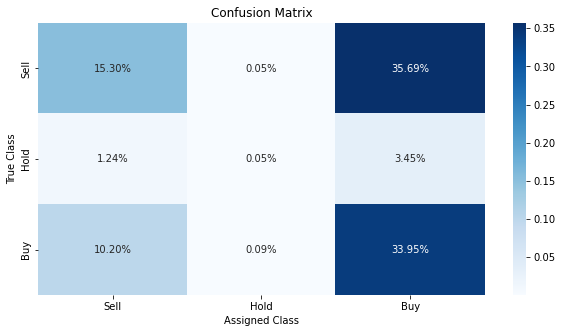

In [ ]:
############## Naive Bayes ##############

#############################
### Kernel PCA Finetuning ###
#############################

kpca_gnb_ft = KernelPCA(random_state = 42, gamma = 0.01, coef0 = 1.04,
                        kernel = "sigmoid", n_components = 8, eigen_solver = "arpack", n_jobs = -1)
gnb = GaussianNB(priors = priors)
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca_gnb_ft], ["ros", ros], ["gnb", gnb]])

param_grid = {
    "scaler": [scaler, None],
    "ros": [ros, None],
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Gaussian Naive Bayes performed best when using Sigmoid Kernel PCA whilst scaling the data. Interestingly, it performed better when not upsampling the data.

### Random Forest

Parameters of the Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 10, 'rf__max_features': 'auto', 'rf__max_depth': 20, 'rf__criterion': 'gini', 'rf__class_weight': None, 'rf__bootstrap': False}
Mean CV score:  0.541759
Standard deviation of CV score:  0.001315
Test Score: 0.541062
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1111
           1       0.11      0.11      0.11       103
           2       0.53      0.60      0.56       963

    accuracy                           0.54      2177
   macro avg       0.41      0.41      0.41      2177
weighted avg       0.54   

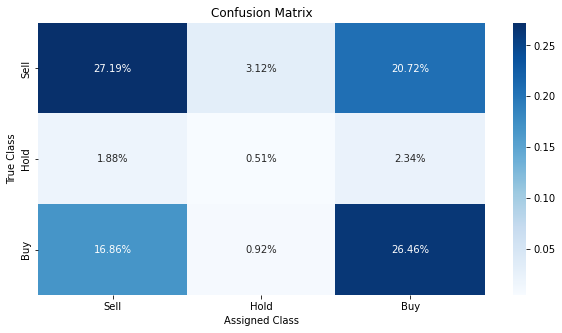

In [ ]:
############## Random Forest ##############

####################
### All Features ###
####################
forest = RandomForestClassifier(random_state = 42)
print(f"Parameters of the Random Forest: {forest.get_params().keys()}")

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

random_grid = {
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 2, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([2, 5, 10, 30, 50]),
    "rf__min_samples_split": np.array([2, 5, 10, 20]),
    "rf__n_estimators": np.array([10, 50, 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__max_depth': 25, 'rf__n_estimators': 70, 'ros': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}
Mean CV score:  0.535430
Standard deviation of CV score:  0.008221
Test Score: 0.526129
              precision    recall  f1-score   support

           0       0.57      0.54      0.56      1111
           1       0.12      0.13      0.12       103
           2       0.52      0.55      0.53       963

    accuracy                           0.53      2177
   macro avg       0.40      0.41      0.40      2177
weighted avg       0.53      0.53      0.53      2177



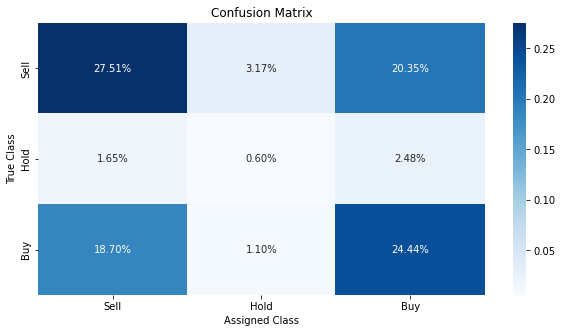

In [ ]:
############## Random Forest ##############

################################
### All Features: Finetuning ###
################################
forest = RandomForestClassifier(random_state = 42, bootstrap = True, class_weight = "balanced", criterion = "gini", max_features = "log2", min_samples_split = 5, min_samples_leaf = 5)

rfpipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["rf", forest]])

param_grid = {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "rf__max_depth": np.array([15, 20, 25, 30]),
    "rf__n_estimators": np.array([30, 40, 50, 60, 70]),
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__max_depth': 20, 'rf__criterion': 'gini', 'rf__class_weight': 'balanced', 'rf__bootstrap': True, 'kpca__n_components': 9, 'kpca__kernel': 'sigmoid', 'kpca__gamma': 0.005, 'kpca__coef0': 1.0222222222222221}
Mean CV score:  0.497718
Standard deviation of CV score:  0.007423
Test Score: 0.500383
              precision    recall  f1-score   support

           0       0.56      0.46      0.51      1111
           1       0.09      0.17      0.12       103
           2       0.51      0.57      0.53       963

    accuracy                           0.49      2177
   macro avg       0.39      0.40      0.39      2177
weighted avg       0.52      0.49      0.50      2177



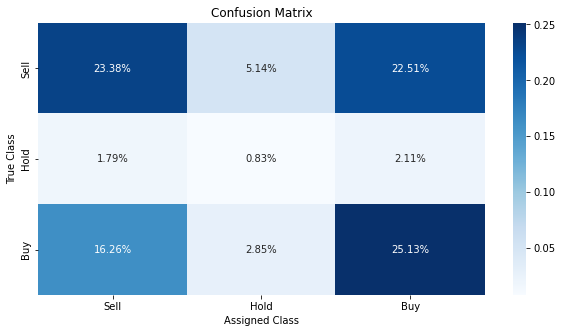

In [47]:
############## Random Forest ##############

##############################################
### Kernel PCA: Broad Hyperparametertuning ###
##############################################
forest = RandomForestClassifier(random_state = 42)
kpca = KernelPCA(random_state = 42)
#kpca = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 8)
rfpipe = imbpipeline(steps=[["scaler", scaler],["kpca", kpca], ["ros", ros], ["rf", forest]])

random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "sigmoid"],
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "kpca__coef0": np.linspace(0.8, 1.2, 10),
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 2, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([2, 5, 10, 30, 50]),
    "rf__min_samples_split": np.array([2, 5, 10, 20]),
    "rf__n_estimators": np.array([10, 50, 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

In [ ]:
############## Random Forest ##############

#############################################
### Kernel PCA: Hyperparameter Finetuning ###
#############################################
forest_ft = RandomForestClassifier(random_state = 42, bootstrap = True, class_weight = "balanced", criterion = "gini", 
                                   max_features = "sqrt", min_samples_leaf= 10, min_samples_split = 5)
kpca_rf_ft = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 9, gamma = 0.005, coef0 = 1.0222222222222221)
rfpipe = imbpipeline(steps=[["scaler", scaler],["kpca", kpca_rf_ft], ["ros", ros], ["rf", forest_ft]])

param_grid = {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "rf__max_depth": np.array([15, 20, 25]),
    "rf__n_estimators": np.array([150, 200, 250]),
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

### Gradient Boosting

Parameters of XGBoost: dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity', 'tree_method'])
Best parameters: {'xgbc__scale_pos_weight': 1, 'xgbc__sampling_method': 'gradient_based', 'xgbc__n_estimators': 1000, 'xgbc__max_depth': 5, 'xgbc__learning_rate': 0.01, 'xgbc__gamma': 0.25, 'scaler': StandardScaler(), 'ros': None}
Mean CV score:  0.575517
Standard deviation of CV score:  0.003373
Test Score: 0.576483
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      1111
           1       0.00      0.00      0.00       103
           2       0.58      0.53      0.55       963

    accuracy                           0.59      2177
   macro avg       0.39     

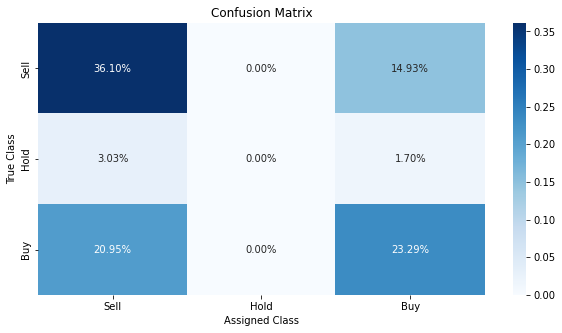

In [27]:
############## Gradient Boosting ##############

####################
### All Features ###
####################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42) # gpu_hist to run on GPU/ cuda to make XGBoost way faster
print(f"Parameters of XGBoost: {xgbc.get_params().keys()}")

xgbc_pipe = imbpipeline([
    ["scaler", scaler],
    ["ros", ros],
    ["xgbc", xgbc],
])


random_grid = {
    "scaler": [None, scaler],
    "ros": [None, ros],
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 200, 500, 1000],
    "xgbc__learning_rate": [0.001, 0.01, 0.05, 0.1],
    "xgbc__gamma": [0, 0.25, 0.5, 0.75, 1],
    "xgbc__scale_pos_weight": [0, sell_prop_trainc/buy_prop_trainc, 1],
    "xgbc__sampling_method": ["uniform", "gradient_based"],

}
##############use randomizedsearch to get broad idea, grid search to finetune
# gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
#                   cv = kFold, n_jobs = -1)
# gs = gs.fit(X_train_cleaned, y_train_cleaned)

rs = RandomizedSearchCV(estimator = xgbc_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 200, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)



get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)




Interestingly, the XGBoost algorithm performed better when not upsampling the data. 

### Support Vector Machine

In [ ]:
############## Support Vector Machine ##############


####################
### All Features ###
####################
svm = SVC(random_state = 42)
print(f"Parameters of the Support Vector Machine: {svm.get_params().keys()}")

svm_pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["SVM", svm]])
random_grid = {
    "SVM__kernel": ["linear", "poly", "rbf", "sigmoid"]
}
# gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted",
                  #cv = kFold,n_jobs = -1)

rs = RandomizedSearchCV(estimator = svm_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 10, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)
# gs = gs.fit(X_train_cleaned, y_train_cleaned)

print(svm.get_params().keys())

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
final_report(y_test_cleaned, y_pred)

### Neural Network

Contrary to most of the previous models, the Neural Network actually performed better without upsampling.

We start by creating a relatively simple feedforward Neural Network with one hidden layer.

In [ ]:
class FinMod1(nn.Module):
  """Feedforward neural network with 1 hidden layer"""
  def __init__(self, input_size, hidden_size, output_size, dropout_rate, activ_func):
    super().__init__()
    # hidden layer (layer between input and output layer)
    self.hidden = nn.Linear(input_size, hidden_size)
    # output layer
    self.output = nn.Linear(hidden_size, 3)
    # Dropout Layer to prevent high correlation (co-adaptation) between layers 
    # without dropout overfitting is likely due to the many parameters/ weights)
    # samples from Bernoulli distribution with p=dropout_rate and randomly sets some elements of the layer output to zero
    self.drop = nn.Dropout(p = dropout_rate)
    # Apply activation function to introduce non-linearity e.g. relu: max(0,x)
    # Without activation function it would just be a linear combination of the input
    self.activ_func = activ_func
  def forward(self, x):
    # Get intermediate outputs using hidden layer
    out = self.hidden(x)
    # Apply activation function to output of hidden layer
    out = self.activ_func(out)
    # randomly zero some elements
    out = self.drop(out)
    # Get predictions using output layer
    out = self.output(out)
    # softmax/ normalized exponential function to get results that lie in (0, 1)
    # returns tensor that can be interpreted as a 3-tuple of predicted probabilities that a observation belongs to the corresponding class
    out = F.softmax(out, dim = 1)
    return out

Next we created a more complex model with two hidden layers to compare it to:

In [ ]:
############## Neural Network ##############

## Standardise cleaned train& test set
X_train_std = sc.fit_transform(X_train_cleaned)
X_test_std = sc.fit_transform(X_test_cleaned)

## Create the model
class FinMod2(nn.Module):
  """Feedforward neural network with 2 hidden layers"""
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_rate1,
               dropout_rate2, activ_func1, activ_func2):
    super().__init__()
    # 1st hidden layer
    self.hidden1 = nn.Linear(input_size, hidden1_size)
    # 2nd hidden layer
    self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
    # output layer
    self.output = nn.Linear(hidden2_size, output_size)
    self.drop1 = nn.Dropout(p = dropout_rate1)
    self.drop2 = nn.Dropout(p = dropout_rate2)
    self.activ_func1 = activ_func1
    self.activ_func2 = activ_func2
  def forward(self, x):
    # Get intermediate outputs using hidden layer
    out = self.hidden1(x)
    # Non linear activation function
    out = self.activ_func1(out)
    # randomly zero some elements
    out = self.drop1(out)
    # pass through 2nd hidden layer
    out = self.hidden2(out)
    # Non-linear activation function
    out = self.activ_func2(out)
    # zero some elements
    out = self.drop2(out)
    # Get predictions using output layer
    out = self.output(out)
    # softmax to get predicted probabilities
    out = F.softmax(out, dim = 1)
    return out

Since matrix multiplications are faster on GPU we decided to load the data and the models onto the GPU (if available).The code necessary for this is from the youtube [PyTorch for Deep Learning](https://youtu.be/GIsg-ZUy0MY?t=14364) course from freeCodeAcademy.org.

In [ ]:
############## Functions for Moving Data and Model to GPU ##############

# Check whether GPU is available
print(torch.cuda.is_available())

# Function to check whether GPU is available or not and select GPU if it is available
def get_device():
  """If possible choose cuda/GPU, otherwise choose CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

device = get_device()
print(device)

# Function to move our data/ model to GPU
def to_device(data, device):
  """Move tensors to GPU"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

# Function that allows to transfer data batchwise to GPU
class DeviceDataLoader():
    """Dataloader to move data to device"""
    def __init__(self, dat_loader, device):
        self.dat_loader = dat_loader
        self.device = device
        
    def __iter__(self):
        """Move batches to device"""
        for batch in self.dat_loader: 
            # use yield to move batches to device one by one and automatically remove from device when it is no longer used
            # this way not all data is moved to the device at once
            yield to_device(batch, self.device) 

    def __len__(self):
        """Return number of batches"""
        return len(self.dat_loader)

True
cuda


To find hyperparameters that yield a good weighted $F_1$-Score we want to define a function that conducts k-fold cross-validation allowing us to evaluate the model for different choices of the hyperparameters. For this we need a way to reset the weights in the beginning of every fold in order to avoid leakage (use of information that should not be available when starting a new fold). The code for this function to reset the weights is from [github](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md#:~:text=self.layers(x)-,Before,-the%20class%2C%20we). There also exists a package called ["skorch"](https://skorch.readthedocs.io/en/stable/user/quickstart.html) that allows for a pipeline and GridSearchCV/ RandomizedSearchCV implementation of PyTorch Neural Networks in the familiar sklearn environment (see appendix for a skorch implementation of our models). We used skorch to get a broad idea of the magnitude of our parameters and then used our own k-fold cross-validation function to finetune the model. In particular, we used skorch to see that the neural network yielded the best results when standardizing the data but **not** upsampling it.

In [ ]:
############## Function for Resetting the Weights of the Model ##############

def reset_weights(model):
  """
  Inputs required: model
  Reset the weights of the model to avoid leakage if code is executed several times
  """
  for layer in model.children():
   if hasattr(layer, "reset_parameters"):
    print(f"Reset trainable parameters of layer = {layer}")
    layer.reset_parameters()

In [ ]:
############## Function for Training and Validating the Model ##############

def train_val_nn(model, n_epochs, train_loader, val_loader, optimizer):
  """
  Inputs required: model, number of epochs, train dataloader, validation dataloader, optimizer
  Trains model using batches from train_loader with the help of forward and backward propagation. Model is then validated using batches from 
  the val_loader. This is done n_epochs many times, where 1 epoch is one batchwise iteration through the whole train & validation set. After each
  epoch the epoch number, average training loss of the epoch and the average validation loss of the epoch is returned.
  """
  torch.manual_seed(42) # set seed, note: does not work perfectly
  # reset weights after every fold to avoid leakage
  reset_weights(model)
  # one epoch is one iteration (forwards and backwards) through all the train and validation examples
  for epoch in range(0, n_epochs):
    ## Training the model
    # model.train() to tell model that we are training so that dropout layers get used
    model.train()
    train_loss = 0
    # for loop to iterate over whole dataloader batchwise
    for X_train_batch, y_train_batch in train_loader:
      # clear existing gradients
      optimizer.zero_grad()
      # Forward Propagation: Input data to get predicted probability that observation belongs to class 0/1/2
      output = model(X_train_batch)
      # Batch loss: compare predicted class with true class; cross entropy is a loss function for multiclass classification
      loss = F.cross_entropy(output, y_train_batch)
      # Calculate the derivative of the loss function
      loss.backward()
      # Backpropagation: Use (stochastic) gradient descent to find direction/ parameters that decrease loss the fastest
      # Use this information to update the model parameters
      optimizer.step()
      # sum up train losses of all batches for this epoch
      train_loss += loss.item() # .item() to return a standard python number
    ## Validating the model
    # model.eval() to tell model that we are testing so that dropout layers do not get used
    model.eval()
    val_loss = 0
    f1_w_val = 0
    # create empty list to store all predicted & true classes
    y_pred = []
    y_true = []
    # we do not want gradient descent for validation set
    with torch.no_grad():
      for X_val_batch, y_val_batch in val_loader:
        output = model(X_val_batch)
        loss = F.cross_entropy(output, y_val_batch)
        # sum up val losses of all batches for this epoch
        val_loss += loss.item()
        # predicted class is the index of the output for which the predicted probability is the highest
        pred_class = torch.argmax(output.data, 1)
        # extend lists by adding predicted class/ true class
        y_pred.extend(pred_class.data.cpu().tolist())
        y_true.extend(y_val_batch.data.cpu().tolist())
    # Calculate average train/ validation loss for epoch
    train_loss /= len(train_loader) # Average Training Loss
    val_loss /= len(val_loader)     # Average validation Loss
    train_val_nn.f1_w_val = metrics.f1_score(y_true, y_pred, average  ="weighted") # validation weighted f1-score
    print(f"Epoch: {epoch+1}/{n_epochs}  |   Training loss: {train_loss: .6f}  |  Validation loss: {val_loss: .6f} | Validation weighted F1-Score: {train_val_nn.f1_w_val: .6f}  ")
  # Calculate weighted F1-Score of validation set for last epoch:
  print()
  print(f"                 Validation weighted F1-Score of last epoch: {train_val_nn.f1_w_val: .6f}")

In [ ]:
############## Function for Testing the Model ##############

def test_nn(model, test_loader):
  """
  Inputs required: model, test data loader
  Predicts classes of the test set using the model (model should already be trained using cross-validation). Returns the average test loss over all batches
  and a heatmap of the confusion matrix as well as a metrics report.
  """
  torch.manual_seed(42)
  # model.eval() to tell model that we are testing so that dropout layers do not get used
  model.eval()
  test_loss = 0
  # create empty list to store all predicted & true classes
  y_pred = []
  y_true = []
  # turn off gradients for testing
  with torch.no_grad():
      for X_test_batch, y_test_batch in test_loader:
          output = model(X_test_batch)
          # test batch loss
          loss = F.cross_entropy(output, y_test_batch) 
          # sum up test losses of all batches
          # use .item() to convert tensor to convert to standard python number
          test_loss += loss.item()
          # argmax to find the index of the largest value of the tensor
          pred_class = torch.argmax(output.data, 1)
          # extend lists by adding predicted class/ true class
          y_pred.extend(pred_class.data.cpu().tolist())
          y_true.extend(y_test_batch.data.cpu().tolist())

  test_loss /= len(test_loader)
  f1_w_test = metrics.f1_score(y_true, y_pred, average  ="weighted")
  print()
  print(f"           Test loss: {test_loss: .6f}  |  Test weighted F1-Score: {f1_w_test: .6f}")
  print()   
  # Return confusion matrix heatmap and metrics report
  final_report(y_true, y_pred)

In [ ]:
############## Function for K-Fold Cross-Validation and Testing the Model ##############

def evaluate_model(model, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer):
  """ 
  Inputs required: model, kFold, standardized X train set, cleaned y train set, standardized X test set, cleaned y test set, batch size, number of epochs, optimizer
  Applies k-fold cross-validation to the model and uses the model with the highest weighted F1-score on the validation set out of all folds to test. Weights get reset
  after every fold. Returns results of each fold, a metrics report for the test set and a heatmap of the confusion matrix for the test set.
  """
  torch.manual_seed(42) # set seed
  f1_w = []
  # Convert to Tensor Datasets
  X_train_ten = torch.from_numpy(X_train_std).type(torch.Tensor)
  y_train_ten = Variable(torch.Tensor(y_train_cleaned).long())
  train_ds = TensorDataset(X_train_ten, y_train_ten)

  for fold, (train, val) in enumerate(kFold.split(X_train_std, y_train_cleaned)): # enumerate to simultaneously save fold nr and split into train and validation set
    print()
    print(f"------------------------------------- FOLD NUMBER: {fold+1} -------------------------------------")
    print()

    # Split into train and validation set
    train_subsampler = SubsetRandomSampler(train)
    val_subsampler = SubsetRandomSampler(val)

    # Define DataLoaders for this fold to allow for batchwise iterations through the dataset
    train_loader = DataLoader(train_ds, batch_size, sampler = train_subsampler)
    val_loader = DataLoader(train_ds, batch_size, sampler = val_subsampler)

    # Move DataLoader to device
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)

    # For each fold train model using train set and validate using validation set; weights get reset at the beginning
    train_val_nn(model, n_epochs, train_loader, val_loader, optimizer)

    # Get average weighted F1-Score of last epoch of fold:
    f1_w.append(train_val_nn.f1_w_val)
    
    # Save the model
    save_path = f"fold-{fold}.pt"
    torch.save(model.state_dict(), save_path)

  reset_weights(model)
  # load model with best weighted f1 score on validation set
  best_fold = np.argmax(f1_w)
  print()
  print(f"                             Best Fold: {best_fold+1}")
  load_path = f"fold-{best_fold}.pt"
  model.load_state_dict(torch.load(load_path))

  # Convert test set to Tensor Dataset
  X_test_ten = torch.from_numpy(X_test_std).type(torch.Tensor)
  y_test_ten = Variable(torch.Tensor(y_test_cleaned).long())
  test_ds = TensorDataset(X_test_ten, y_test_ten)

  # Define Test DataLoader to allow for batchwise iterations through test dataset
  test_loader = DataLoader(test_ds, batch_size, shuffle = True)
  # Move DataLoader to device
  test_loader = DeviceDataLoader(test_loader, device)
  # Test the model
  test_nn(model, test_loader)



------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=146, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=3, bias=True)
Epoch: 1/40  |   Training loss:  1.035686  |  Validation loss:  1.005571 | Validation weighted F1-Score:  0.432765  
Epoch: 2/40  |   Training loss:  0.991766  |  Validation loss:  0.986486 | Validation weighted F1-Score:  0.451437  
Epoch: 3/40  |   Training loss:  0.978598  |  Validation loss:  0.978155 | Validation weighted F1-Score:  0.476777  
Epoch: 4/40  |   Training loss:  0.972402  |  Validation loss:  0.975464 | Validation weighted F1-Score:  0.503742  
Epoch: 5/40  |   Training loss:  0.968801  |  Validation loss:  0.972880 | Validation weighted F1-Score:  0.506500  
Epoch: 6/40  |   Training loss:  0.966901  |  Validation loss:  0.970815 | Validation weighted F1-Score:  0.507225  
Epoch: 7/40  |   Training

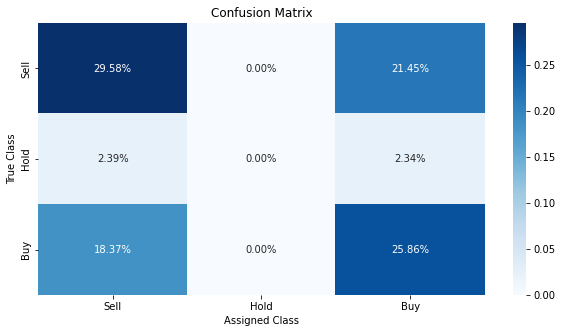

In [ ]:
n_epochs = 40
input_size = 146 # nr of features
num_classes = 3
dropout_rate = 0.2
hidden = 100
# Initialize model
model1 = FinMod1(input_size, hidden, num_classes, dropout_rate, F.tanh)
# Move model ot device
to_device(model1, device)
# Initialize optimizer:

#optimizer1 = torch.optim.Adam(model1.parameters(), lr = 1e-4) 
batch_size = 16 # number of training examples in one forward and backward pass

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9) #initialize optimizer
evaluate_model(model1, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer1)


------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=146, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=25, bias=True)
Reset trainable parameters of layer = Linear(in_features=25, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.014301  |  Validation loss:  0.984459 | Validation weighted F1-Score:  0.429759  
Epoch: 2/100  |   Training loss:  0.974759  |  Validation loss:  0.973714 | Validation weighted F1-Score:  0.482513  
Epoch: 3/100  |   Training loss:  0.967892  |  Validation loss:  0.969241 | Validation weighted F1-Score:  0.495064  
Epoch: 4/100  |   Training loss:  0.965418  |  Validation loss:  0.968257 | Validation weighted F1-Score:  0.510600  
Epoch: 5/100  |   Training loss:  0.964640  |  Validation loss:  0.967304 | Validation weighted F1-Score:  0.511842  
Epoch: 6/100  |   Training loss:  0.962400  |  V

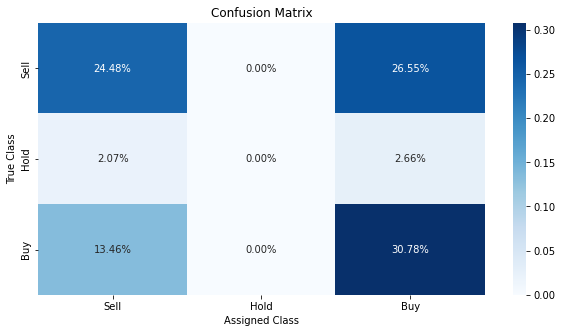

In [ ]:
batch_size = 32
n_epochs =  40
hidden1 = 100
hidden2 = 25
dropout_rate = 0.2
dropout_rate2 = 0.15
model2 = FinMod2(input_size, hidden1, hidden2, num_classes, dropout_rate, dropout_rate2, F.tanh, F.tanh)
to_device(model2, device)
#optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1.9e-4) 
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.8) #initialize optimizer

evaluate_model(model2, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer2)

## Feature Engineering

## Appendix

In [ ]:
!pip install -U skorch
from skorch import NeuralNetClassifier

     |████████████████████████████████| 155 kB 4.3 MB/s 


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9068       0.5165        0.8615  0.4127
      2        0.8661       0.5254        0.8488  0.4212
      3        0.8550       0.5234        0.8440  0.4391
      4        0.8482       0.5323        0.8414  0.4083
      5        0.8472       0.5310        0.8401  0.4012
      6        0.8449       0.5351        0.8395  0.4045
      7        0.8426       0.5344        0.8390  0.4153
      8        0.8422       0.5338        0.8385  0.4061
      9        0.8399       0.5346        0.8382  0.4104
     10        0.8389       0.5300        0.8383  0.4038
Best parameters: {'net__lr': 0.01, 'net__module__activ_func': <function tanh at 0x7f7ea22b0440>, 'net__module__dropout_rate': 0.15, 'net__module__hidden_size': 100, 'ros': None, 'scaler': None}
Mean CV score:  0.523159
Standard deviation of CV score:  0.007787
Test Score: 0.510899
              precision    recall 

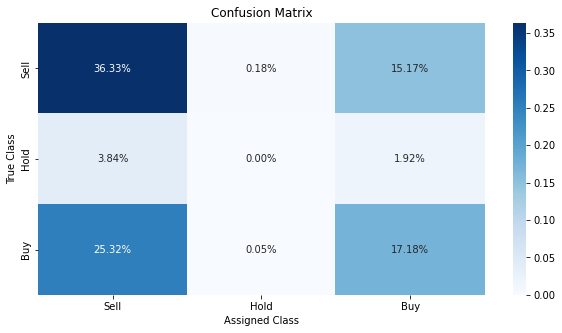

In [ ]:
net = NeuralNetClassifier(
    module=FinMod1,
    max_epochs = 10,
    lr = 0.01,
    module__input_size = 146,
    module__output_size = 3,
    module__hidden_size=100,
    module__dropout_rate=0.2,
    module__activ_func=F.relu,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.SGD,
    device = "cuda"
)

pipe = imbpipeline(steps=[["scaler", scaler],
                          ["ros", ros], ["net", net]])

param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "net__module__hidden_size": [90, 100, 110],
    "net__module__dropout_rate": [0.15, 0.2, 0.25],
    "net__module__activ_func": [F.relu, F.leaky_relu, F.tanh],
    "net__lr": [0.001, 0.01]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
X_train_cleaned_f, y_train_cleaned_i = X_train_cleaned.astype(np.float32), y_train_cleaned.astype(np.int64)
gs = gs.fit(X_train_cleaned_f, y_train_cleaned_i)

X_test_cleaned_f, y_test_cleaned_i = X_test_cleaned.astype(np.float32), y_test_cleaned.astype(np.int64)
get_results_cv(gs, X_test_cleaned_f, y_test_cleaned_i)
y_pred = gs.best_estimator_.predict(X_test_cleaned_f)
final_report(y_test_cleaned, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9115       0.5165        0.8575  0.4177
      2        0.8666       0.5242        0.8487  0.4398
      3        0.8570       0.5277        0.8453  0.4155
      4        0.8512       0.5247        0.8433  0.4199
      5        0.8514       0.5275        0.8418  0.4126
      6        0.8500       0.5270        0.8406  0.4253
      7        0.8476       0.5285        0.8398  0.4343
      8        0.8461       0.5277        0.8392  0.4453
      9        0.8446       0.5293        0.8388  0.4151
     10        0.8442       0.5303        0.8383  0.4191
Best parameters: {'net__module__activ_func1': <function tanh at 0x7fcd3c3784d0>, 'net__module__activ_func2': <function tanh at 0x7fcd3c3784d0>, 'net__module__dropout_rate1': 0.2, 'net__module__dropout_rate2': 0.2, 'net__module__hidden1_size': 100, 'net__module__hidden2_size': 20, 'ros': None, 'scaler': None}
Mean C

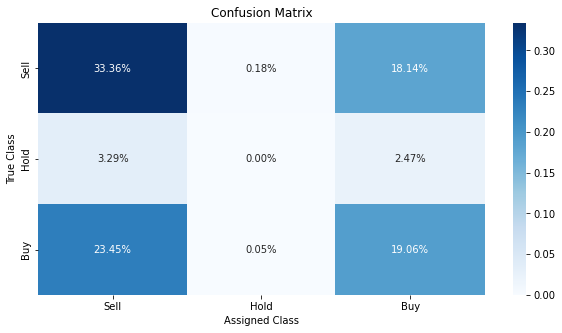

In [ ]:
net = NeuralNetClassifier(
    module=FinMod2,
    max_epochs = 10,
    lr = 0.01,
    module__input_size = 146,
    module__output_size = 3,
    module__hidden1_size= 100,
    module__hidden2_size = 30,
    module__dropout_rate1 =0.2,
    module__dropout_rate2 = 0.2,
    module__activ_func1 = F.relu,
    module__activ_func2 = F.relu, 
    criterion=torch.nn.NLLLoss,
    device = "cuda"
)

pipe = imbpipeline(steps=[["scaler", scaler],
                          ["ros", ros], ["net", net]])

param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "net__module__hidden1_size": [80, 100],
    "net__module__hidden2_size": [10, 20],
    "net__module__dropout_rate1": [0.2, 0.4],
    "net__module__dropout_rate2": [0.2, 0.4],
    "net__module__activ_func1": [F.relu, F.leaky_relu, F.tanh],
    "net__module__activ_func2": [F.relu, F.leaky_relu, F.tanh],

}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
X_train_cleaned_f, y_train_cleaned_i = X_train_cleaned.astype(np.float32), y_train_cleaned.astype(np.int64)
gs = gs.fit(X_train_cleaned_f, y_train_cleaned_i)

X_test_cleaned_f, y_test_cleaned_i = X_test_cleaned.astype(np.float32), y_test_cleaned.astype(np.int64)
get_results_cv(gs, X_test_cleaned_f, y_test_cleaned_i)
y_pred = gs.best_estimator_.predict(X_test_cleaned_f)
final_report(y_test_cleaned, y_pred)